In [3]:
import matplotlib.image as mpimg
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from PIL import Image

In [4]:
tf.test.is_gpu_available()

True

In [5]:
import os

In [6]:
trdata=[]
for info in os.listdir('C:\\Users\\User\\Desktop\\images\\train_r'):
    domain = os.path.abspath('C:\\Users\\User\\Desktop\\images\\train_r')
    info = os.path.join(domain,info)
    pil_im = Image.open(info)
    pil_im = pil_im.resize((224,224))
    pil_im = np.array(pil_im)/255.0
    pil_im = pil_im[:,:,0]*0.299+pil_im[:,:,1]*0.587+pil_im[:,:,2]*0.114
    pil_im = np.reshape(pil_im,(-1,224,224,1))
    pil_im = pil_im.astype('float32')
    trdata.append(pil_im)
trdata=np.array(trdata)

In [7]:
ytdata=[]
for info in os.listdir('C:\\Users\\User\\Desktop\\images\\train_3.4.3'):
    domain = os.path.abspath('C:\\Users\\User\\Desktop\\images\\train_3.4.3')
    info = os.path.join(domain,info)
    pil_im = Image.open(info)
    pil_im = pil_im.resize((224,224))
    pil_im = np.array(pil_im)/255.0
    pil_im = pil_im[:,:,0]*0.299+pil_im[:,:,1]*0.587+pil_im[:,:,2]*0.114
    pil_im = np.reshape(pil_im,(-1,224,224,1))
    pil_im = pil_im.astype('float32')
    ytdata.append(pil_im)
ytdata=np.array(ytdata)

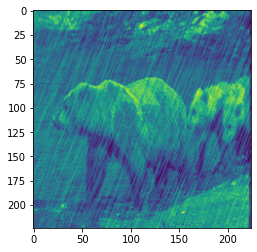

In [8]:
plt.imshow(np.squeeze(trdata[0]))

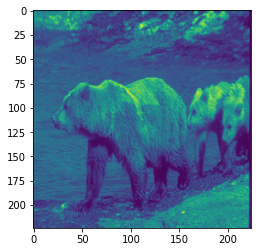

In [9]:
plt.imshow(np.squeeze(ytdata[0]))

In [10]:
#224*224*300=15052800
from tensorflow import keras
from tensorflow.keras import layers
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (4, 4),activation='relu',padding='same', input_shape=(224, 224, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (4, 4),padding='same',activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (4, 4),padding='same',activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(512, (4, 4),strides=(1, 1),padding='same',activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(1, (4, 4),strides=(1, 1),padding='same',activation='relu'))#(64*4*4)+(128*4*4)+(256*4*4)+(512*4*4)+(4*4)=15376
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(50176, activation='relu'))
    model.add(layers.Reshape((224,224,1)))
    return model

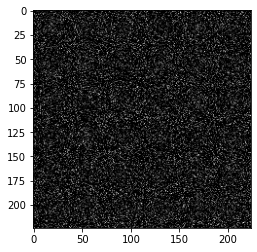

In [11]:
generator = make_generator_model()

generated_image = generator(trdata[0], training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [12]:
generated_image.shape

TensorShape([1, 224, 224, 1])

In [13]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     131200    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 256)       524544    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 512)       2

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def generator_loss(fake_output,real):
    real=tf.convert_to_tensor(real)
    return (tf.norm((fake_output-real),ord='fro',axis=(0,1)))**2

In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), padding='same',
                                     input_shape=[224, 224, 1]))
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    return model

In [19]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[2.118319e-05]], shape=(1, 1), dtype=float32)


In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [23]:
EPOCHS = 500

In [24]:
@tf.function
def train_step(images,yi):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(images, training=True)

      real_output = discriminator(yi, training=True)
      fake_output = discriminator(generated_images, training=True)
      gen_loss = generator_loss(generated_images,yi)
      #gen_loss = generator_loss(fake_output,yi)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [25]:
import time
def train(trdataset,ydataset ,epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch,yi in zip(trdataset,ydataset):
      train_step(image_batch,yi)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


In [26]:
train(trdata,ytdata,EPOCHS)

Time for epoch 1 is 17.893280506134033 sec
Time for epoch 2 is 15.642230033874512 sec
Time for epoch 3 is 15.705929040908813 sec
Time for epoch 4 is 15.78062629699707 sec
Time for epoch 5 is 15.795821905136108 sec
Time for epoch 6 is 15.799699783325195 sec
Time for epoch 7 is 15.855560064315796 sec
Time for epoch 8 is 15.783755540847778 sec
Time for epoch 9 is 15.761620283126831 sec
Time for epoch 10 is 15.758480787277222 sec
Time for epoch 11 is 15.811845302581787 sec
Time for epoch 12 is 15.836920022964478 sec
Time for epoch 13 is 15.87842845916748 sec
Time for epoch 14 is 15.862006902694702 sec
Time for epoch 15 is 19.485631942749023 sec
Time for epoch 16 is 15.874181270599365 sec
Time for epoch 17 is 15.863894701004028 sec
Time for epoch 18 is 15.85029673576355 sec
Time for epoch 19 is 15.826749324798584 sec
Time for epoch 20 is 15.917617321014404 sec
Time for epoch 21 is 15.956413984298706 sec
Time for epoch 22 is 15.936362743377686 sec
Time for epoch 23 is 15.873342752456665 sec


Time for epoch 188 is 16.296586751937866 sec
Time for epoch 189 is 16.25299334526062 sec
Time for epoch 190 is 16.251287698745728 sec
Time for epoch 191 is 16.26347804069519 sec
Time for epoch 192 is 16.271294593811035 sec
Time for epoch 193 is 16.22655439376831 sec
Time for epoch 194 is 16.26572585105896 sec
Time for epoch 195 is 19.994322299957275 sec
Time for epoch 196 is 16.106017351150513 sec
Time for epoch 197 is 16.253448247909546 sec
Time for epoch 198 is 16.262950897216797 sec
Time for epoch 199 is 16.222466945648193 sec
Time for epoch 200 is 16.20747661590576 sec
Time for epoch 201 is 16.23018741607666 sec
Time for epoch 202 is 16.21760606765747 sec
Time for epoch 203 is 16.218217134475708 sec
Time for epoch 204 is 16.2025203704834 sec
Time for epoch 205 is 16.221692323684692 sec
Time for epoch 206 is 16.233184814453125 sec
Time for epoch 207 is 16.26541519165039 sec
Time for epoch 208 is 16.249279737472534 sec
Time for epoch 209 is 16.215842723846436 sec
Time for epoch 210 i

Time for epoch 372 is 15.998684883117676 sec
Time for epoch 373 is 16.00505566596985 sec
Time for epoch 374 is 15.961354970932007 sec
Time for epoch 375 is 19.742925882339478 sec
Time for epoch 376 is 15.829020500183105 sec
Time for epoch 377 is 15.913506984710693 sec
Time for epoch 378 is 15.9255051612854 sec
Time for epoch 379 is 15.911322832107544 sec
Time for epoch 380 is 15.92807126045227 sec
Time for epoch 381 is 15.934428215026855 sec
Time for epoch 382 is 15.941844463348389 sec
Time for epoch 383 is 15.94414472579956 sec
Time for epoch 384 is 15.93506669998169 sec
Time for epoch 385 is 15.941695213317871 sec
Time for epoch 386 is 15.937271118164062 sec
Time for epoch 387 is 15.962101221084595 sec
Time for epoch 388 is 15.942665815353394 sec
Time for epoch 389 is 16.019843578338623 sec
Time for epoch 390 is 19.28254723548889 sec
Time for epoch 391 is 15.88134479522705 sec
Time for epoch 392 is 16.00348973274231 sec
Time for epoch 393 is 15.98850154876709 sec
Time for epoch 394 i

In [106]:
genee = generator(trdata[44], training=False)

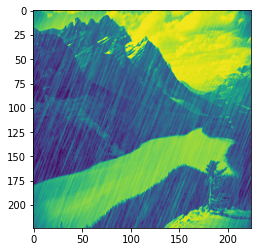

In [107]:
plt.imshow(np.squeeze(trdata[44]))

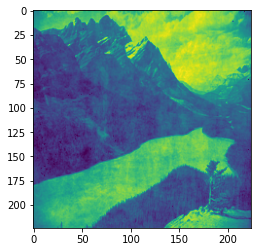

In [108]:
genee=np.squeeze(genee)
plt.imshow(genee)